## Init

In [15]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'/src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [16]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


## Data Preparation

In [21]:
from scripts.matlab.load_time_course_data import load_timecourse_data
from scripts.matlab.load_target_data import load_target_data
from models.Utils import last_time_point_method, dynamic_features_method
import pandas as pd 
import pickle

file_path = f'{config["DATA_PATH"]}/matlab_output/ground_truth_data.csv'
simulation_data = pd.read_csv(file_path, index_col=0)
feature_data_file_path = f'notebooks/tests/shared_dir/src/feature_data.pkl'
with open(feature_data_file_path, 'rb') as f:
    feature_data = pickle.load(f)
ground_time_course_data = load_timecourse_data(simulation_data, index_option='cell_id')
target_data = load_target_data(simulation_data, 'pERK', index_option='cell_id')

all_species = list(ground_time_course_data.columns)
# remove 'pERK' from all_species since it is the target variable
all_species.remove('pERK')

last_time_data = last_time_point_method(ground_time_course_data, all_species)
dynamic_data = dynamic_features_method(ground_time_course_data, all_species, n_cores=8)

combined_lp_data = pd.concat([feature_data, last_time_data], axis=1)
combined_dyn_data = pd.concat([feature_data, dynamic_data], axis=1)

feature_data_list = [feature_data, last_time_data, dynamic_data, combined_lp_data, combined_dyn_data]
feature_data_names = ['feature_data', 'last_time_data', 'dynamic_data', 'combined_lp_data', 'combined_dyn_data']
o_random_seed = 42
target_name = 'pERK'

In [22]:
import pandas as pd
import numpy as np

def sample_feature_datasets(feature_data_list, min_samples=50, max_samples=250, step=50, random_seed=42):
    """
    Subsamples a list of feature datasets to common indices.

    Parameters:
    - feature_data_list (List[pd.DataFrame]): List of dataframes to be subsampled.
    - min_samples (int): Minimum number of samples.
    - max_samples (int): Maximum number of samples.
    - step (int): Step size for number of samples.
    - random_seed (int): Seed for reproducible sampling.

    Returns:
    - dict[int, List[pd.DataFrame]]: Dictionary with sample size as key and list of sampled DataFrames as value.
    """
    if not feature_data_list:
        raise ValueError("Input feature_data_list is empty.")
    
    # Find common indices across all dataframes
    common_index = set(feature_data_list[0].index)
    for df in feature_data_list[1:]:
        common_index &= set(df.index)
    
    common_index = sorted(common_index)
    rng = np.random.default_rng(random_seed)

    sampled_datasets = {}

    for n_samples in range(min_samples, max_samples + 1, step):
        if n_samples > len(common_index):
            raise ValueError(f"Requested {n_samples} samples, but only {len(common_index)} common indices available.")
        
        sampled_idx = rng.choice(common_index, size=n_samples, replace=False)
        sampled_batch = [df.loc[sampled_idx].copy() for df in feature_data_list]
        sampled_datasets[n_samples] = sampled_batch

    return sampled_datasets


## Machine Learning 

In [ ]:
import pandas as pd
from ml.Workflow import batch_eval_standard

# Sample datasets
sampled_dict = sample_feature_datasets(
    feature_data_list,
    min_samples=50,
    max_samples=250,
    step=50,
    random_seed=o_random_seed
)

all_results = []

for sample_size, sampled_data_list in sampled_dict.items():
    print(f"Running evaluation for sample size = {sample_size}...")

    metric_df = batch_eval_standard(
        feature_data_list=sampled_data_list,
        feature_data_names=feature_data_names,
        target_data=target_data,
        target_name=target_name,
        num_repeats=10,
        test_size=0.2,
        o_random_seed=o_random_seed,
        n_jobs=-1
    )

    metric_df["sample_size"] = sample_size
    all_results.append(metric_df)

    print(f"Completed: sample size = {sample_size}, shape = {metric_df.shape}")

final_df = pd.concat(all_results, ignore_index=True)
output_file_path = f'{config["DATA_PATH"]}/matlab_output/exp22_sampled_eval_results.pkl' 
with open(output_file_path, 'wb') as f:
    pickle.dump(final_df, f)
print(f"Results saved to {output_file_path}")

## Visualisation

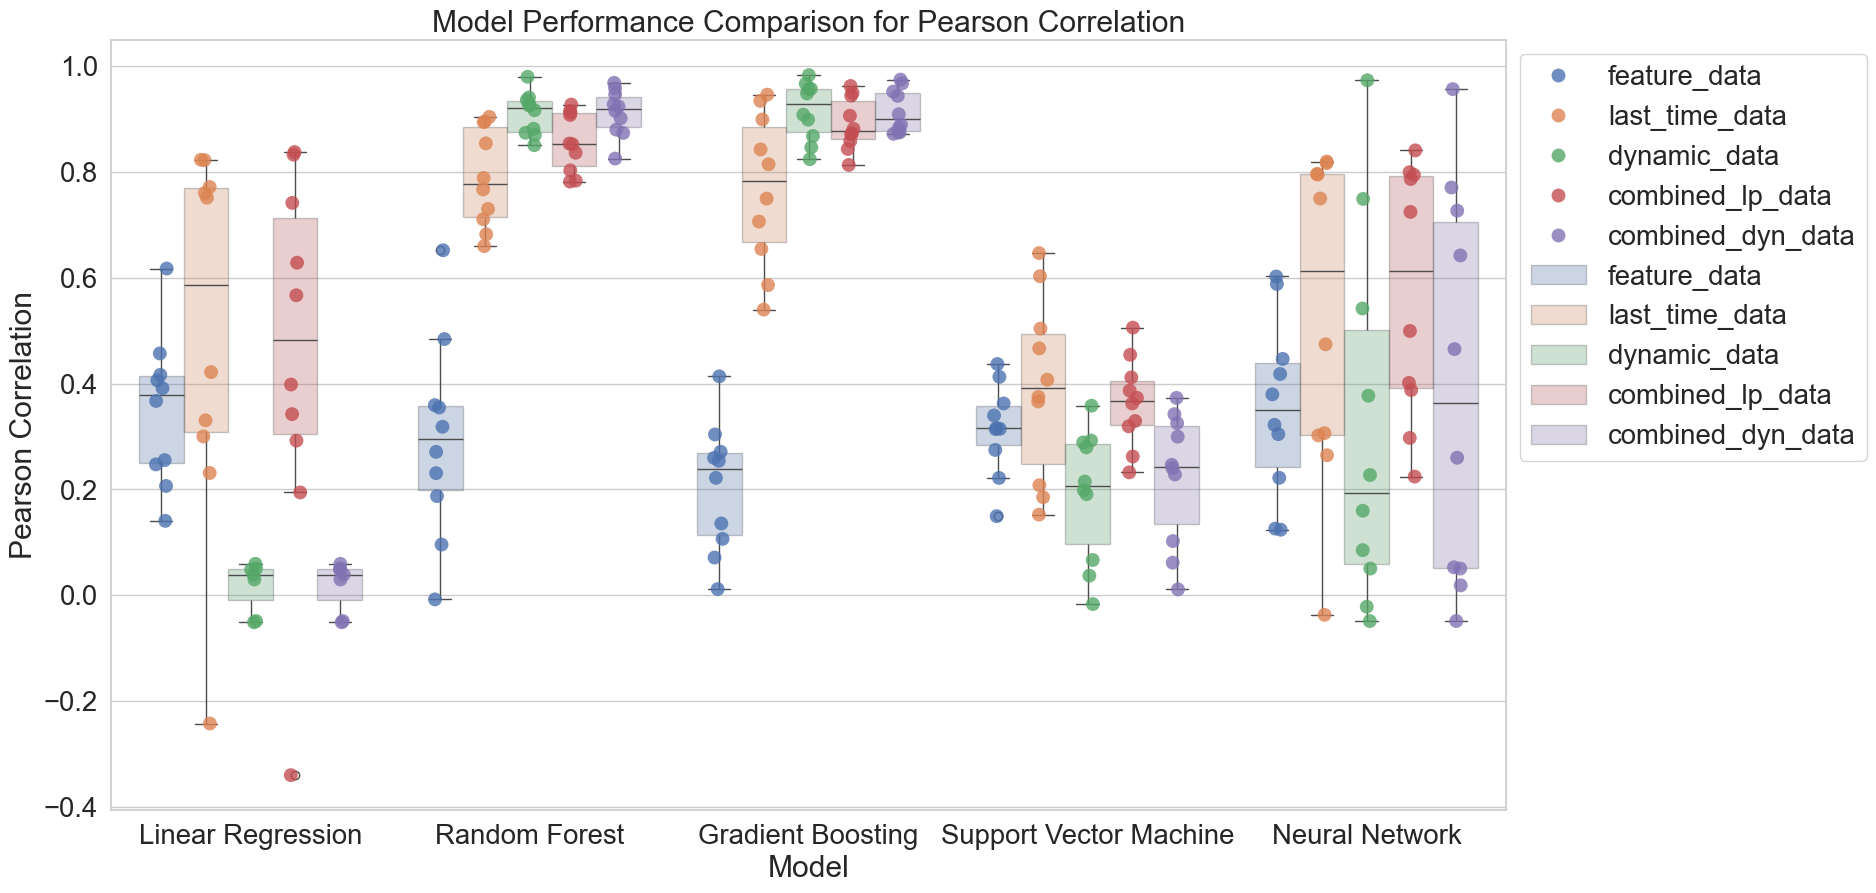

In [16]:
# create box plots for each model type and feature data type, plot for pearson correlation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

sns.set(rc={'figure.figsize':(18,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)

# display the mean value for each model and feature data type
mean_vals = metric_df.groupby(['Model', 'Feature Data']).mean().reset_index()
    

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Pearson Correlation')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

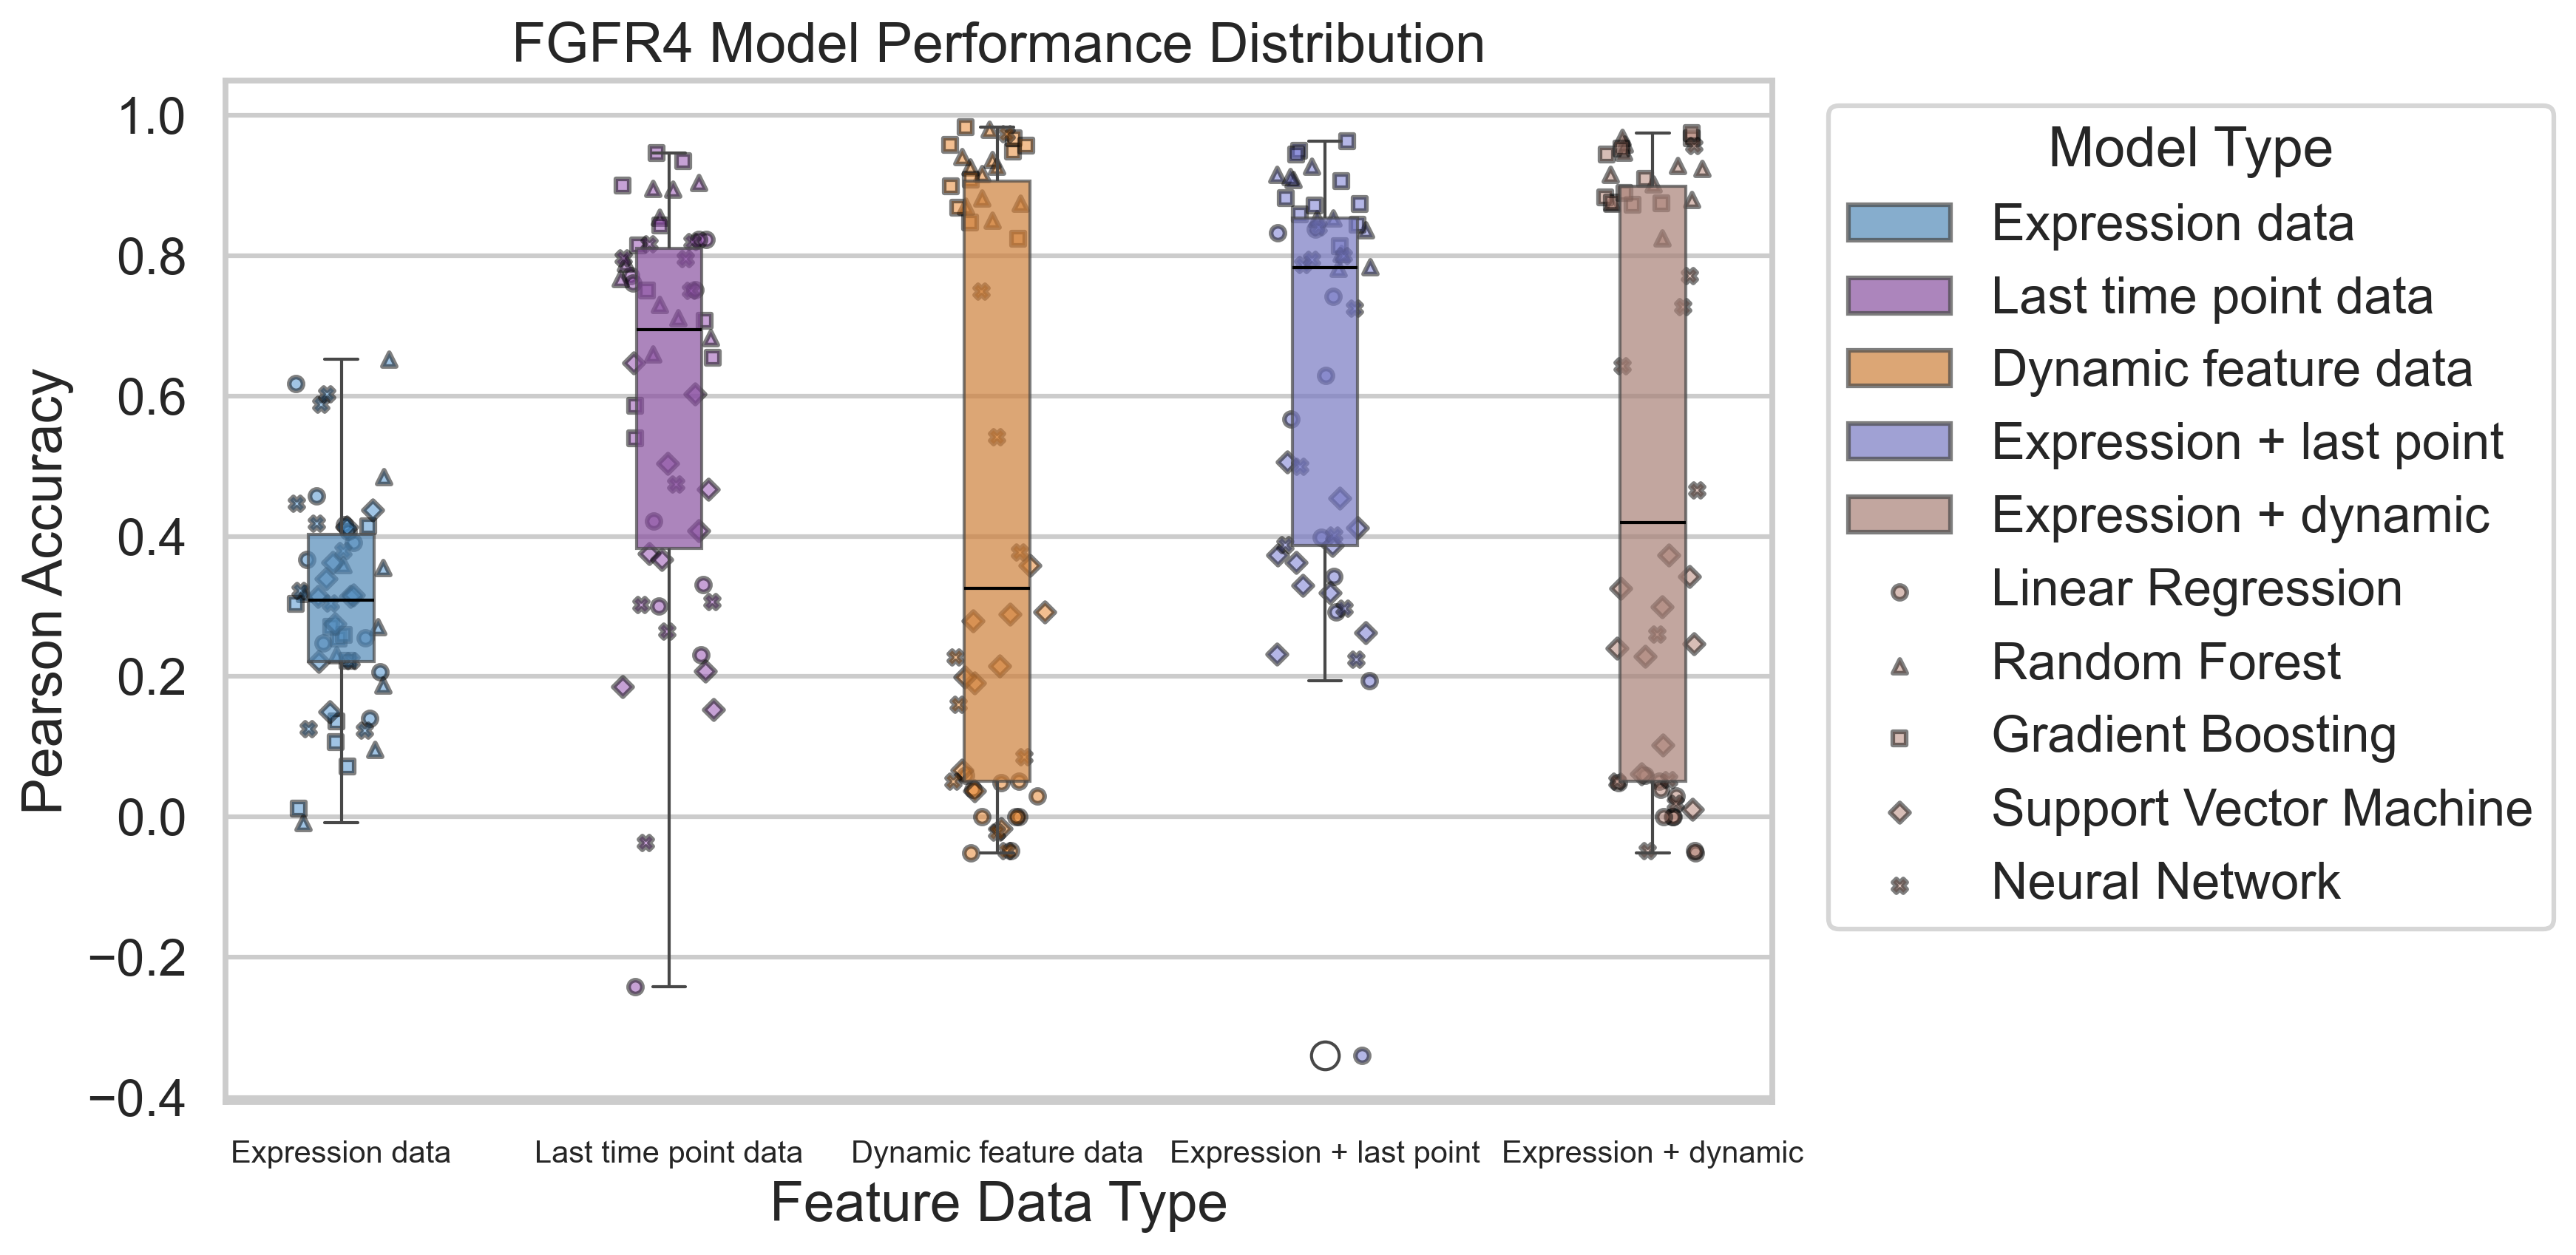

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import numpy as np

metric_df.fillna(0, inplace=True)  # Fill NaN values with 0 for plotting

# Define custom markers for each model
model_markers = {
    'Linear Regression': 'o',
    'Random Forest': '^',
    'Gradient Boosting': 's',
    'Support Vector Machine': 'D',
    'Neural Network': 'X'
}

# Color map for feature data types
color_map = {
    'Expression data': '#428bca',
    'Last time point data': '#8e44ad',
    'Dynamic feature data': '#e67e22',
    'Expression + last point': '#6b6fcf',
    'Expression + dynamic': '#b07c6f'
}

# Preprocess data
plot_data = metric_df.copy()
plot_data['Feature Data'] = plot_data['Feature Data'].replace({
    'feature_data': 'Expression data',
    'last_time_data': 'Last time point data',
    'dynamic_data': 'Dynamic feature data',
    'combined_lp_data': 'Expression + last point',
    'combined_dyn_data': 'Expression + dynamic',
    'combined expression + last time point': 'Expression + last point',
    'combined expression + dynamic feature': 'Expression + dynamic'
})


# Get consistent order for feature types
feature_order = list(color_map.keys())

# Plot setup
plt.figure(figsize=(12, 6), dpi=300)
sns.set_context("talk", font_scale=1)
sns.set_style("whitegrid")
matplotlib.rcParams['font.family'] = 'Arial'

# Boxplot
ax = sns.boxplot(
    data=plot_data,
    x='Feature Data',
    y='Pearson Correlation',
    hue='Feature Data',            # Explicitly assign hue
    palette=color_map,
    width=0.2,
    showcaps=True,
    boxprops={'alpha': 0.7},
    medianprops={'color': 'black'},
    legend=True                   # Suppress duplicate legend
)

# Overlay points with custom markers per model
x_positions = {cat: i for i, cat in enumerate(feature_order)}

for model_name, marker in model_markers.items():
    subset = plot_data[plot_data['Model'] == model_name]
    for _, row in subset.iterrows():
        x = x_positions[row['Feature Data']] + np.random.uniform(-0.15, 0.15)
        y = row['Pearson Correlation']
        ax.scatter(x, y,
                   color=color_map[row['Feature Data']],
                   marker=marker,
                   s=20,
                   edgecolor='black',
                   alpha=0.5,
                   label=model_name)

# De-duplicate model legend
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), title="Model Type", bbox_to_anchor=(1.02, 1), loc='upper left')

# Axis styling
plt.title('FGFR4 Model Performance Distribution')
plt.xlabel('Feature Data Type')
plt.ylabel('Pearson Accuracy')
plt.xticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()
